# New Scaling

***

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import Normalize
from matplotlib import cm
import os
import gsw
from datetime import datetime, timedelta
from dateutil.parser import parse
from tqdm import tqdm_notebook as tqdm
from warnings import simplefilter
from dynmodes import dynmodes
from salishsea_tools import viz_tools, geo_tools

%matplotlib inline
simplefilter('ignore')
plt.rcParams['font.size'] = 12

***

## Local Functions and Definitions

In [3]:
def build_GEM_mask(lon_HRDPS, lat_HRDPS, lon_NEMO, lat_NEMO, mask_NEMO):
    """
    """

    # Preallocate
    m, n = lon_HRDPS.shape
    mask_HRDPS = np.zeros(m*n, dtype=int)

    # Evaluate each point on GEM grid
    for index, lon, lat in zip(tqdm(range(m*n)), lon_HRDPS.flatten() - 360, lat_HRDPS.flatten()):

        j, i = geo_tools.find_closest_model_point(lon, lat, lon_NEMO, lat_NEMO)
        if j is np.nan or i is np.nan:
            mask_HRDPS[index] = 0
        else:
            mask_HRDPS[index] = mask_NEMO[j, i]

    # Reshape
    mask_HRDPS = mask_HRDPS.reshape(m, n)

    return mask_HRDPS

In [24]:
def calc_deformation_radius(rho, z_h, yx, e1t=440, angle=np.pi/2, tol=10, northerly=False):
    """Calculate the baroclinic Rossby deformation radius
    """

    scalefac = np.sin(angle) * e1t
    g_prime = const['g'] * (const['rho_0'] - rho) / const['rho_0']
    R = np.sqrt(g_prime * z_h * (const['H'] - z_h) / const['H']) / const['f']
    H, H_old = const['H'], 0
    while abs(H - H_old) > tol:
        H_old = H
        H = bathy.Bathymetry[yx]
        if northerly: H = H[::-1]
        H = float(H[~np.isnan(H)][:int(R / scalefac)].mean())
        R = np.sqrt(g_prime * z_h * (H - z_h) / H) / const['f']

    return R

In [5]:
def calc_rho(data, depth, yx, tmask):
    """Calculate the density, rho
    """
    
    loc = (0,) + yx if type(depth) is int else (slice(None),) + yx
    rho = gsw.rho(*[np.ma.masked_where(tmask[loc] == 0, data[k][loc]) for k in tracers], depth)
    
    return rho

In [14]:
def make_prefix(date, path, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results/SalishSea/hindcast.201812/ddmmmyy/SalishSea_1h_yyyymmdd_yyyymmdd
    """

    datestr = [date.strftime('%d%b%y').lower(), '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))]
    prefix = os.path.join(path, datestr[0], f'SalishSea_1{res}_{datestr[1]}')
    
    return prefix

In [174]:
# Definitions
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
grid_HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
const = {'g': 9.81, 'f': 1.11e-4, 'rho_0': 1024, 'H': 200, 'R': 5e3, 'z_h': 10}
depth2d = np.expand_dims(mask.gdept_1d[0, :], axis=1)
tracers = ['vosaline', 'votemper']
subdomain = [114, 398, 334, 898]
sections = [
    {'yx': (455, slice(237, 320)), 'yw': (138, 142), 'xw': (141, 153), 'aS': np.arctan(10), 'aN': np.arctan( 10), 'c': 'r'},
    {'yx': (540, slice(175, 255)), 'yw': (152, 156), 'xw': (124, 135), 'aS': np.arctan( 1), 'aN': np.arctan(1.5), 'c': 'gold'},
    {'yx': (625, slice(132, 192)), 'yw': (167, 169), 'xw': (111, 119), 'aS': np.arctan(10), 'aN': np.arctan(  2), 'c': 'c'},
    {'yx': (689, slice(125, 195)), 'yw': (179, 182), 'xw': (107, 116), 'aS': np.arctan( 5), 'aN': np.arctan(  2), 'c': 'cyan'},
    #{'yx': (500, slice(205, 295)), 'yw': (145, 153), 'xw': (134, 141), 'a': np.arctan( 1), 'c': 'darkorange'},
    #{'yx': (590, slice(130, 205)), 'yw': (159, 166), 'xw': (114, 121), 'a': np.arctan( 2), 'c': 'darkslategray'},
]
for sec in sections:
    sec['e1t'] = float(mask.e1t[(0,) + sec['yx']].mean())
    for key in ['xw', 'yw']:
        sec[key] = np.round(np.linspace(*sec[key], 12)).astype(int)

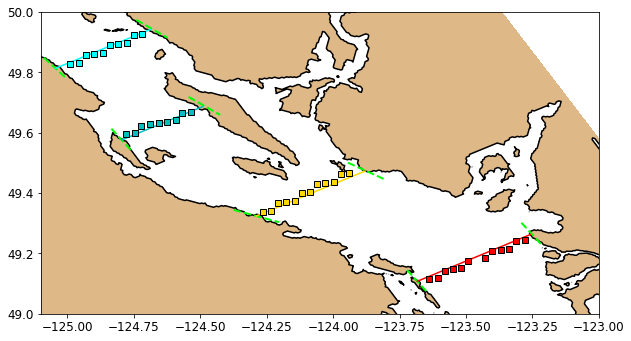

In [175]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([-125.1, -123])
ax.set_ylim([49, 50])
viz_tools.set_aspect(ax)
for attr, color in zip(['contourf', 'contour'], ['Burlywood', 'k']):
    getattr(ax, attr)(bathy.nav_lon, bathy.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors=color)

for sec in sections:
    for angle, attr in zip(['aS', 'aN'], ['start', 'stop']):
        line = []
        lon, lat = [0, 0], [0, 0]
        for coord, slope in zip([sec['yx'][0], getattr(sec['yx'][1], attr)], [-1, np.tan(sec[angle])]):
            line.append([coord + w / slope for w in [-10, 10]])
        for i, y, x in zip(range(2), *line):
            lon[i], lat[i] = [bathy[key][int(y), int(x)].values for key in ('nav_lon', 'nav_lat')]
        ax.plot(lon, lat, '--', linewidth=2, color='lime')
    ax.plot(bathy.nav_lon[sec['yx']], bathy.nav_lat[sec['yx']], color=sec['c'])
    ax.plot(grid_HRDPS.longitude.values[sec['yw'], sec['xw']]-360, grid_HRDPS.latitude.values[sec['yw'], sec['xw']], 'ks', markerfacecolor=sec['c'])

***

## Hindcast scaling results

In [176]:
# Define paths and variables
path_NEMO = '/results2/SalishSea/nowcast-green.201812'
tmask = mask.tmask[0, ...]
depthw = (depth2d[1:, 0] + depth2d[:-1, 0]) / 2

In [177]:
# Upwelling event date windows
dates_south = [
    '2015 Mar 11 04:00',
    '2015 Mar 18 17:00',
    '2015 Mar 24 22:00',
    '2015 Mar 28 18:00',
    '2015 Apr 02 17:00',
    '2015 Apr 09 20:00',
    '2015 Apr 12 18:00',
    '2015 Apr 25 23:00',
    '2015 Aug 28 00:00',
    '2015 Sep 18 00:00',
    '2015 Sep 22 16:00',
    '2016 Mar 23 10:00',
    '2016 Apr 11 13:00',
    '2016 Jun 01 18:00',
    '2016 Jul 07 14:00',
    '2016 Aug 28 12:00',
    '2016 Sep 16 12:00',
    '2016 Sep 22 20:00',
    '2017 Mar 01 20:00',
    '2017 Mar 06 23:00',
    '2017 Mar 11 07:00',
    '2017 Mar 16 12:00',
    '2017 Mar 21 15:00',
    '2017 Mar 26 08:00',
    '2017 Apr 03 23:00',
    '2017 Apr 07 19:00',
    '2017 Apr 13 12:00',
    '2017 Apr 17 18:00',
    '2017 May 15 12:00',
    '2017 May 30 04:00',
    '2017 Jun 14 17:00',
    '2017 Sep 08 23:00',
    '2017 Sep 17 02:00',
    '2017 Oct 21 05:00',
    '2018 Mar 14 00:00',
    '2018 Mar 22 07:00',
    '2018 Mar 25 19:00',
    '2018 Apr 04 08:00',
    '2018 Apr 07 07:00',
    '2018 Apr 12 23:00',
    '2018 Apr 20 12:00',
    '2018 Jun 01 12:00',
    '2018 Jun 05 12:00',
    '2018 Sep 07 13:00',
    '2018 Sep 14 13:00',
    '2018 Sep 20 17:00',
    '2018 Oct 23 06:00',
]

In [178]:
# Upwelling event date windows
dates_north = [
    '2015 Apr 21 02:00',
    '2015 May 01 20:00',
    '2015 Jun 05 06:00',
    '2015 Jun 30 00:00',
    '2015 Jul 14 00:00',
    '2015 Jul 30 03:00',
    '2015 Aug 16 06:00',
    '2015 Sep 10 06:00',
    '2016 Mar 27 10:00',
    '2016 Apr 24 06:00',
    '2016 Apr 29 03:00',
    '2016 May 04 03:00',
    '2016 Jul 24 18:00',
    '2016 Aug 10 14:00',
    '2016 Sep 10 18:00',
    '2016 Sep 27 03:00',
    '2017 Apr 02 02:00',
    '2017 May 23 20:00',
    '2017 Jun 20 15:00',
    '2017 Jun 26 03:00',
    '2017 Jul 23 03:00',
    '2017 Jul 31 03:00',
    '2017 Sep 12 00:00',
    '2018 Apr 01 08:00',
    '2018 May 11 00:00',
    '2018 May 28 16:00',
    '2018 Jun 15 06:00',
    '2018 Jul 01 06:00',
    '2018 Jul 11 03:00',
    '2018 Sep 25 02:00',
]

In [179]:
def calc_upwelling_metrics(dates, hour=24, northerly=False):
    """
    """
    
    angle = 'aN' if northerly else 'aS'
    
    # Preallocate storage variables
    events = []
    rho_t0 = [0, 0, 0, 0, 0, 0]

    # Loop though events and hours
    for date in tqdm(dates):
        event = {}
        event['date'] = parse(date)
        event['sections'] = [{}, {}, {}, {}, {}, {}]

        # Loop through hours
        for hour in [0, hour]:
            time = event['date'] + timedelta(hours=hour)

            # Open hindcast record
            with xr.open_dataset(make_prefix(time, path_NEMO) + '_grid_T.nc') as data:

                # Loop through sections
                for n, sec, esec in zip(range(6), sections, event['sections']):

                    # Calculations at t=0
                    if hour == 0:

                        # Calculate stratification parameters
                        rho_t0[n] = calc_rho(data.sel(time_counter=time, method='nearest'), depth2d, sec['yx'], tmask)
                        if northerly: rho_t0[n] = np.flip(rho_t0[n], axis=1)
                        N2 = const['g'] / const['rho_0'] * np.diff(rho_t0[n], axis=0) / np.diff(depth2d, axis=0)
                        modes = dynmodes(np.ma.median(N2[:, :20], axis=1).compressed()[:24], depthw[:24], 1)
                        z_h = depthw[int(np.where(np.diff(np.signbit(modes[1][0, :])))[0])]
                        rho_surf = rho_t0[n][:int(z_h), :].mean()
                        rho_halo = np.median(rho_t0[n][abs(depth2d[:, 0] - z_h).argmin(axis=0), :])
                        R = calc_deformation_radius(rho_surf, z_h, sec['yx'], angle=sec[angle], northerly=northerly)
                        esec.update({'rho_halo': rho_halo, 'rho_surf': rho_surf, 'R': R, 'z_h': z_h})

                    # Calculations at hours
                    else:

                        # Calculate tau
                        u, v = [HRDPS.sel(time=slice(event['date'], time))[k].values[:, sec['yw'], sec['xw']] for k in ['u_wind', 'v_wind']]
                        coeff = np.cos(np.pi * (22 / 180 + 1) - np.arctan2(v, u) - sec[angle])
                        tau = sum(1.225e-3 * (coeff * (u**2 + v**2)).mean(axis=1)) * 3600

                        # Calculate upwelling metrics
                        rho = calc_rho(data.sel(time_counter=time, method='nearest'), 0, sec['yx'], tmask)
                        if rev: rho = rho[::-1]
                        rho_max = rho[:max(1, int(esec['R'] / sec['e1t']))].max()
                        z_u = depth2d[int(np.median(abs(rho_t0[n] - rho_max).argmin(axis=0))), 0]
                        x_u = np.sin(sec[angle]) * (rho >= esec['rho_halo']).sum() * sec['e1t']
                        esec.update({'tau': tau, 'z_u': z_u, 'x_u': x_u})
        events.append(event)
        
    return events

In [181]:
events = calc_upwelling_metrics(dates_north, northerly=True)

### Scaling plots

### Southerly

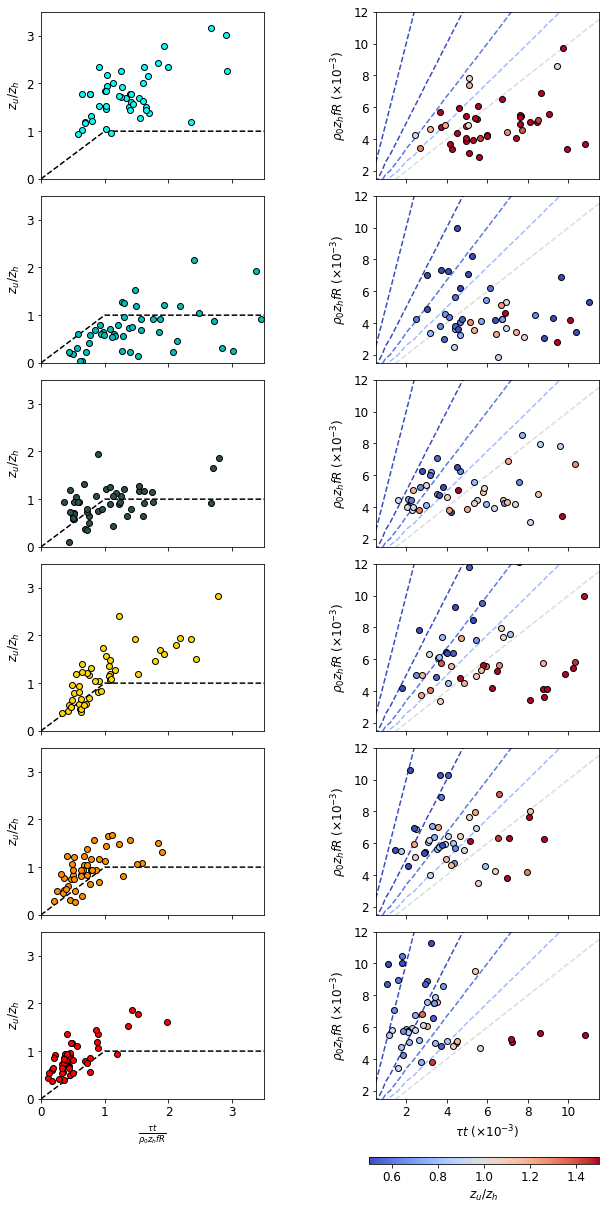

In [250]:
x, y = np.meshgrid(np.arange(0, 15), np.arange(0, 15))
norm = Normalize(vmin=0.5, vmax=1.5)
m = cm.ScalarMappable(norm=norm, cmap=cm.coolwarm)
levels=[0.2, 0.4, 0.6, 0.8, 1]

xlims, ylims = [(0, 3.5), (0.5, 11.5)], [(0, 3.5), (1.5, 12)]
xlabels, ylabels = ['$\\frac{\\tau t}{\\rho_0 z_h f R}$', '$\\tau t$ ($\\times 10^{-3}$)'], ['$z_u / z_h$', '$\\rho_0 z_h f R$ ($\\times 10^{-3}$)']

fig, axs = plt.subplots(6, 2, figsize=(10, 20), gridspec_kw={'hspace': 0.1, 'wspace': 0.5})
cax = fig.add_axes([0.58, 0.08, 0.32, 0.005])
for n, row in enumerate(axs):
    for ax, xlim, ylim, xlabel, ylabel in zip(row, xlims, ylims, xlabels, ylabels):
        ax.plot((0, 1, 3.5), (0, 1, 1), 'k--')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_ylabel(ylabel)
        if n == 5: ax.set_xlabel(xlabel)
        else: ax.xaxis.set_ticklabels('')
    row[1].contour(x, y, x/y, levels=levels, colors=m.to_rgba(levels), linestyles='dashed')

for event in events:
    for row, sec, section in zip(axs[::-1, :], sections, event['sections']):
        scaling = const['rho_0'] * section['z_h'] * const['f'] * section['R']
        scaling2 = const['rho_0'] * const['z_h'] * const['f'] * const['R']
        row[0].plot(section['tau'] / scaling, section['z_u'] / section['z_h'], 'ko', markerfacecolor=sec['c'])
        row[1].plot(section['tau'] * 1e-3, scaling * 1e-3, 'ko', markerfacecolor=m.to_rgba(section['z_u'] / section['z_h']))
        
m.set_array([])
fig.colorbar(m, cax=cax, orientation='horizontal', label='$z_u / z_h$')

### Northerly

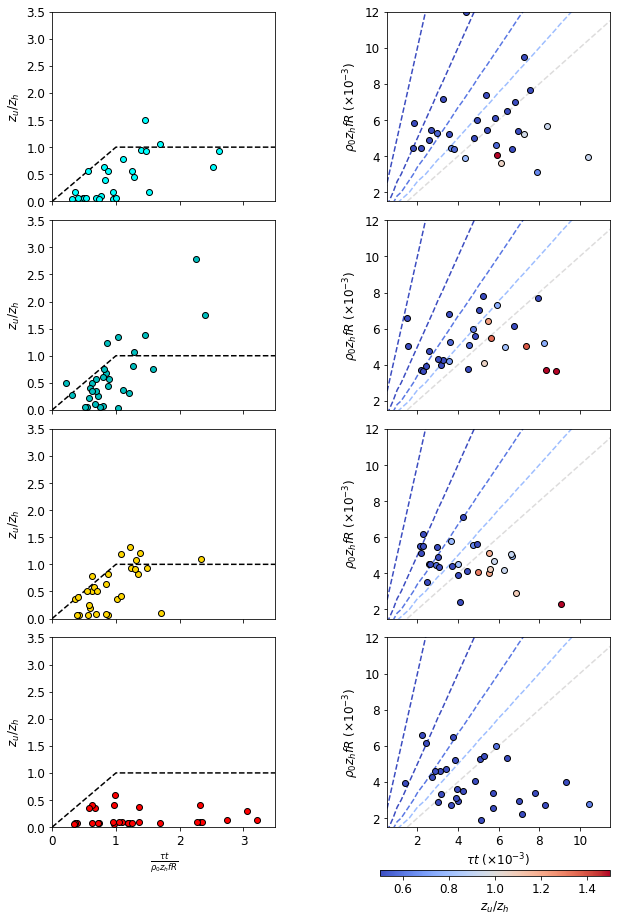

In [182]:
x, y = np.meshgrid(np.arange(0, 15), np.arange(0, 15))
norm = Normalize(vmin=0.5, vmax=1.5)
m = cm.ScalarMappable(norm=norm, cmap=cm.coolwarm)
levels=[0.2, 0.4, 0.6, 0.8, 1]

xlims, ylims = [(0, 3.5), (0.5, 11.5)], [(0, 3.5), (1.5, 12)]
xlabels, ylabels = ['$\\frac{\\tau t}{\\rho_0 z_h f R}$', '$\\tau t$ ($\\times 10^{-3}$)'], ['$z_u / z_h$', '$\\rho_0 z_h f R$ ($\\times 10^{-3}$)']

fig, axs = plt.subplots(4, 2, figsize=(10, 15), gridspec_kw={'hspace': 0.1, 'wspace': 0.5})
cax = fig.add_axes([0.58, 0.08, 0.32, 0.005])
for n, row in enumerate(axs):
    for ax, xlim, ylim, xlabel, ylabel in zip(row, xlims, ylims, xlabels, ylabels):
        ax.plot((0, 1, 3.5), (0, 1, 1), 'k--')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_ylabel(ylabel)
        if n == 3: ax.set_xlabel(xlabel)
        else: ax.xaxis.set_ticklabels('')
    row[1].contour(x, y, x/y, levels=levels, colors=m.to_rgba(levels), linestyles='dashed')

for event in events:
    for row, sec, section in zip(axs[::-1, :], sections, event['sections']):
        scaling = const['rho_0'] * section['z_h'] * const['f'] * section['R']
        scaling2 = const['rho_0'] * const['z_h'] * const['f'] * const['R']
        row[0].plot(-1*section['tau'] / scaling, section['z_u'] / section['z_h'], 'ko', markerfacecolor=sec['c'])
        row[1].plot(-1*section['tau'] * 1e-3, scaling * 1e-3, 'ko', markerfacecolor=m.to_rgba(section['z_u'] / section['z_h']))
        
m.set_array([])
fig.colorbar(m, cax=cax, orientation='horizontal', label='$z_u / z_h$')

### Wind timeseries

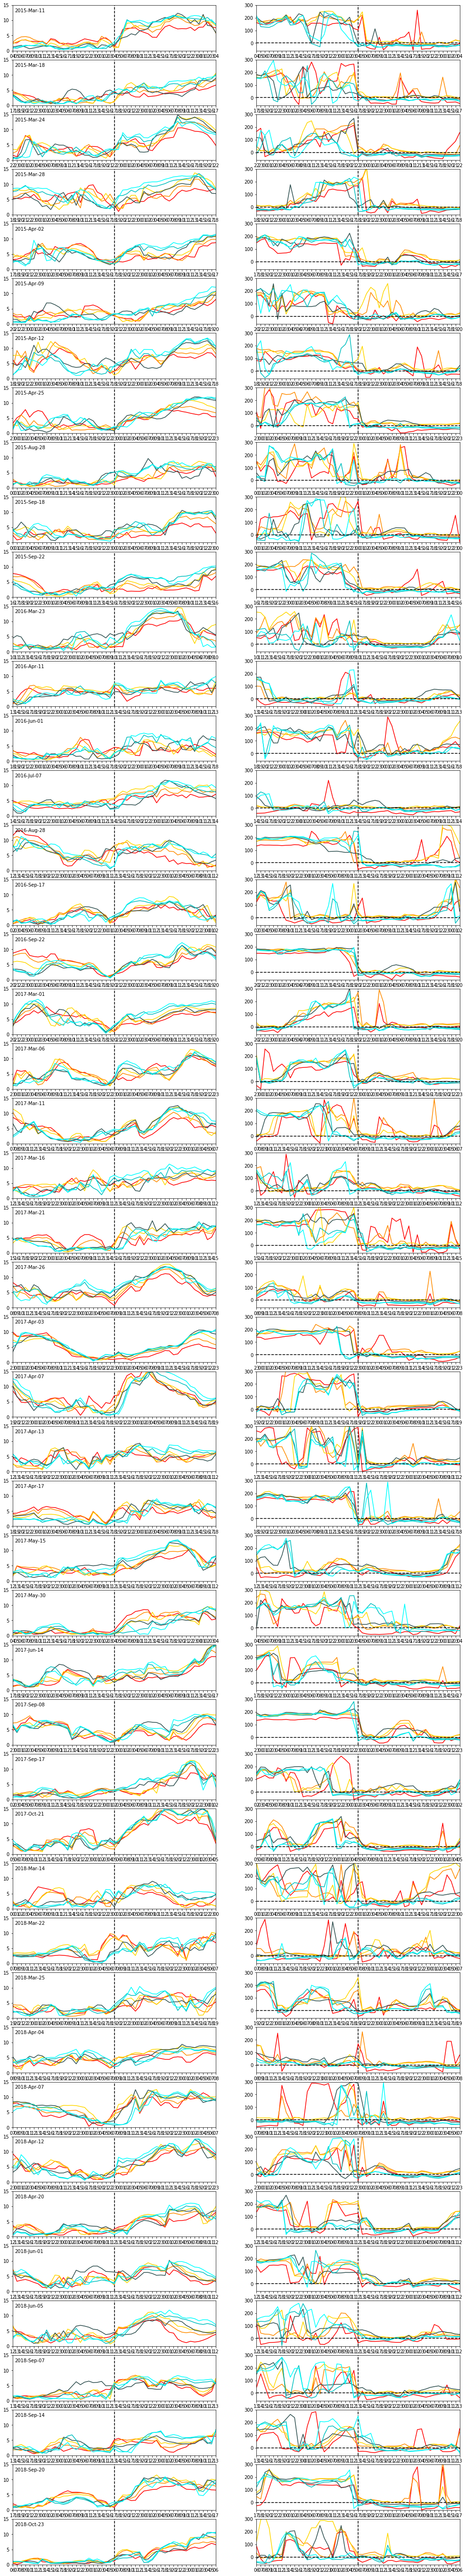

In [192]:
# Make figure layout
fig, axs = plt.subplots(47, 2, figsize=(17, 100))

# Loop though events and hours
for row, event in zip(tqdm(axs), events):
    date = (event - timedelta(hours=24), event + timedelta(hours=24))
    time = HRDPS.sel(time=slice(*date)).time
    for ax, ylim in zip(row, [(0, 15), (-60, 300)]):
        ax.set_xlim(date)
        ax.set_ylim(ylim)
        ax.xaxis.set_major_locator(mdates.HourLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
        ax.plot([event, event], ylim, 'k--')
    for sec in sections:
        u, v = [HRDPS.sel(time=slice(*date))[k].values[:, sec['yw'], sec['xw']] for k in ['u_wind', 'v_wind']]
        mag = np.sqrt(u**2 + v**2).mean(axis=1)
        angle = 180 * (1 - (np.arctan2(v, u).mean(axis=1) + sec['a']) / np.pi) + 22
        row[0].plot(time, mag, '-', color=sec['c'])
        row[1].plot(time, angle, '-', color=sec['c'])
    row[0].text(0.01, 0.85, event.strftime('%Y-%b-%d'), transform=row[0].transAxes)
    row[1].plot(date, [0, 0], 'k--')

In [12]:
# Upwelling event date windows
dates2 = [
    '2015 Apr 21 02:00', #1
    '2015 May 01 20:00', #2
    '2015 Jun 05 06:00', #3
    '2015 Jun 30 00:00', #4
    '2015 Jul 14 00:00', #5
    '2015 Jul 30 03:00', #6
    '2015 Aug 16 06:00', #7
    '2015 Sep 10 06:00', #8
    '2016 Mar 27 10:00', #9
    '2016 Apr 24 06:00', #10
    '2016 Apr 29 03:00', #11
    '2016 May 04 03:00', #12
    '2016 Jul 24 18:00', #13
    '2016 Aug 10 14:00', #14
    '2016 Sep 10 18:00', #15
    '2016 Sep 27 03:00', #16
    '2017 Apr 02 02:00', #17
    '2017 May 23 20:00', #18
    '2017 Jun 20 15:00', #19
    '2017 Jun 26 03:00', #20
    '2017 Jul 23 03:00', #21
    '2017 Jul 31 03:00', #22
    '2017 Sep 12 00:00', #23
    '2018 Apr 01 08:00', #24
    '2018 May 11 00:00', #25
    '2018 May 28 16:00', #26
    '2018 Jun 15 06:00', #27
    '2018 Jul 01 06:00', #28
    '2018 Jul 11 03:00', #29
    '2018 Sep 25 02:00', #30
]

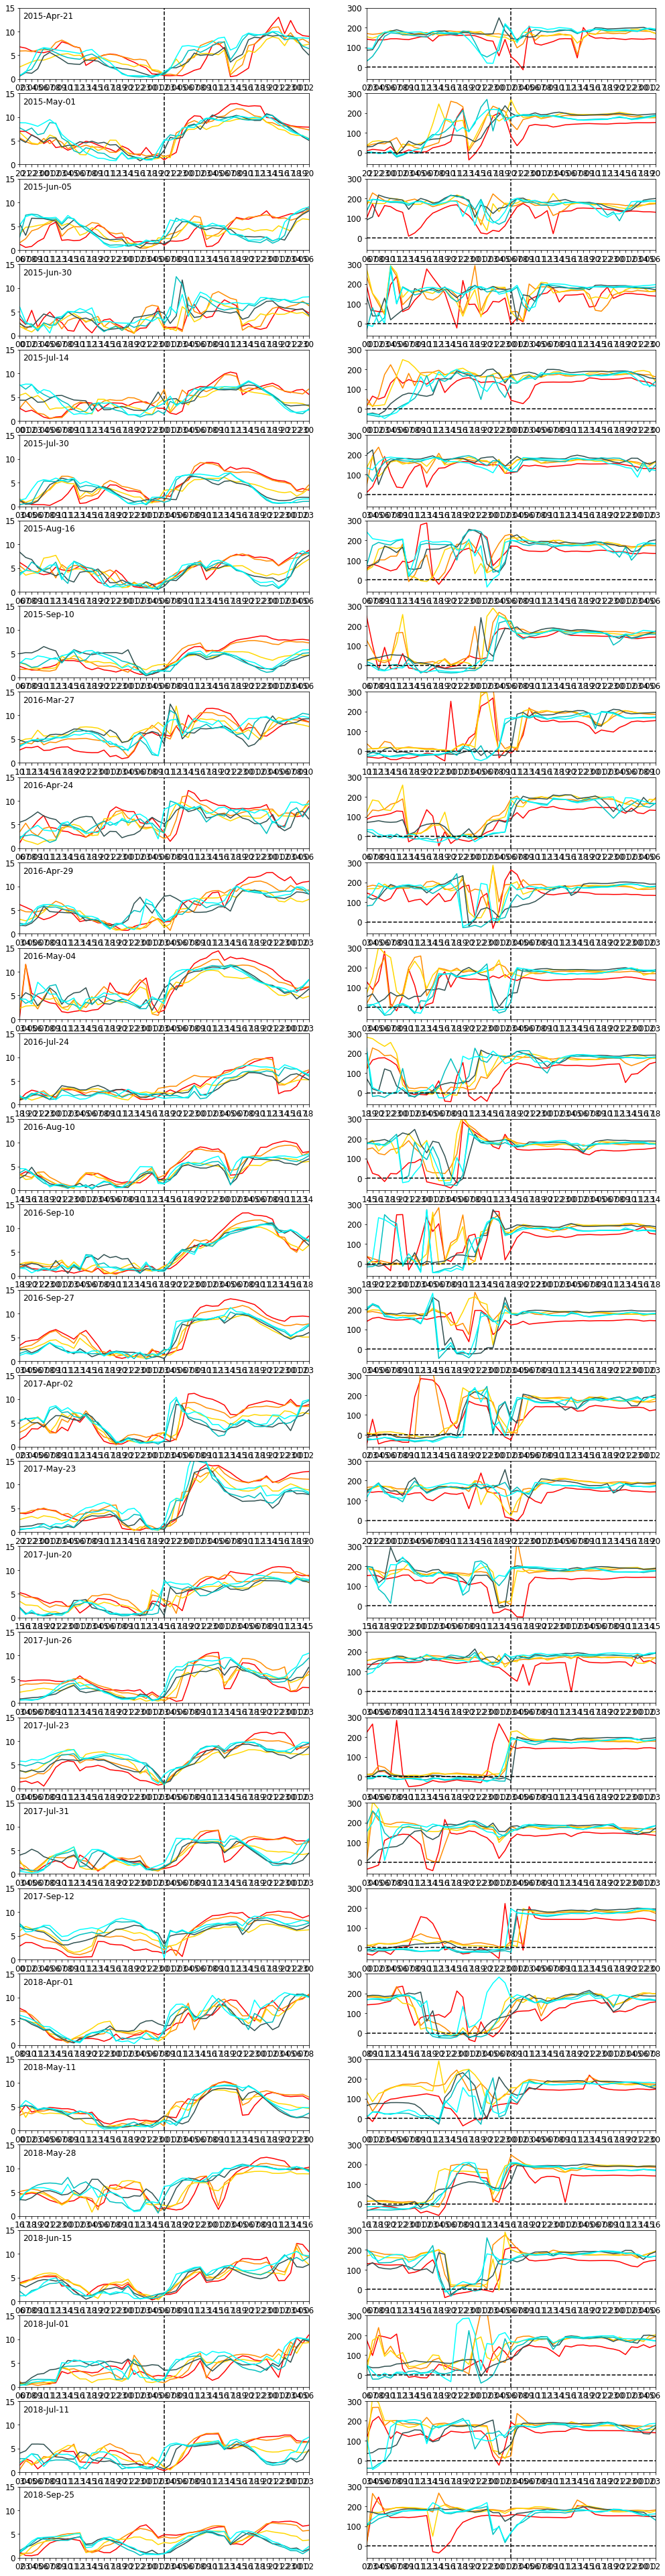

In [282]:
# Make figure layout
fig, axs = plt.subplots(30, 2, figsize=(17, 70))

# Loop though events and hours
for row, Date in zip(tqdm(axs), dates2):
    date = parse(Date)
    daterange = (date - timedelta(hours=24), date + timedelta(hours=24))
    time = HRDPS.sel(time=slice(*daterange)).time
    for ax, ylim in zip(row, [(0, 15), (-60, 300)]):
        ax.set_xlim(daterange)
        ax.set_ylim(ylim)
        ax.xaxis.set_major_locator(mdates.HourLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
        ax.plot([date, date], ylim, 'k--')
    for sec in sections:
        u, v = [HRDPS.sel(time=slice(*daterange))[k].values[:, sec['yw'], sec['xw']] for k in ['u_wind', 'v_wind']]
        mag = np.sqrt(u**2 + v**2).mean(axis=1)
        angle = 180 * (1 - (np.arctan2(v, u).mean(axis=1) + sec['a']) / np.pi) + 22
        row[0].plot(time, mag, '-', color=sec['c'])
        row[1].plot(time, angle, '-', color=sec['c'])
    row[0].text(0.01, 0.85, date.strftime('%Y-%b-%d'), transform=row[0].transAxes)
    row[1].plot(daterange, [0, 0], 'k--')